In [1]:
import os 

current_dir = os.getcwd()
current_dir, current_base = os.path.split(current_dir)

if current_base == "notebooks":
    os.chdir('..')

In [2]:
from utils import download_dataset 

In [3]:
download_dataset('cat', 'ndjson')

In [30]:
import json

strokes = []
n_strokes = []
recognized = []
# Open the NDJSON file
with open('data/cat.ndjson') as f:
    # Loop through each line in the file
    max_strokes = 0
    for line in f:
        # Load the JSON data from the line
        data = json.loads(line)
        n_strokes_ = len(data['drawing'])
        if n_strokes_ > 10:
            continue
        for i in range(1,n_strokes_):
            strokes.append(data['drawing'][0:i])
            n_strokes.append(i)
            recognized.append(1 if data['recognized'] else 0)
        if n_strokes_ > max_strokes:
            max_strokes = n_strokes_

In [ ]:
np.linspace()

In [31]:
import numpy as np
import cairocffi as cairo
from tqdm import tqdm

colors

def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in tqdm(vector_images):
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for i, (xv, yv) in enumerate(centered):
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [32]:
strokes = np.array(vector_to_raster(strokes[:10]))
strokes = strokes.reshape((strokes.shape[0], 28, 28))

100%|████████████████████████████████████| 10/10 [00:00<00:00, 2084.54it/s]

1
2
3
4
5
6
7
8
1
2


In [13]:
eye = np.eye(max_strokes)
n_strokes = np.apply_along_axis(lambda c: eye[c], axis=0, arr=np.array(n_strokes))[:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
np.unique(recognized, return_counts=True)

(array([0, 1]), array([ 51634, 431954]))

In [17]:
np.unique(n_strokes, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([74652, 74130, 72515, 68969, 62243, 52083, 39686, 26398, 12912]))

In [ ]:
import torch
from torch.utils.data import Dataset

class PartialDrawingDataset(Dataset):
    def __itnit(self, strokes, n_strokes, recognized):
        self.strokes = strokes
        self.n_strokes = n_strokes
        self.recognized = recognized

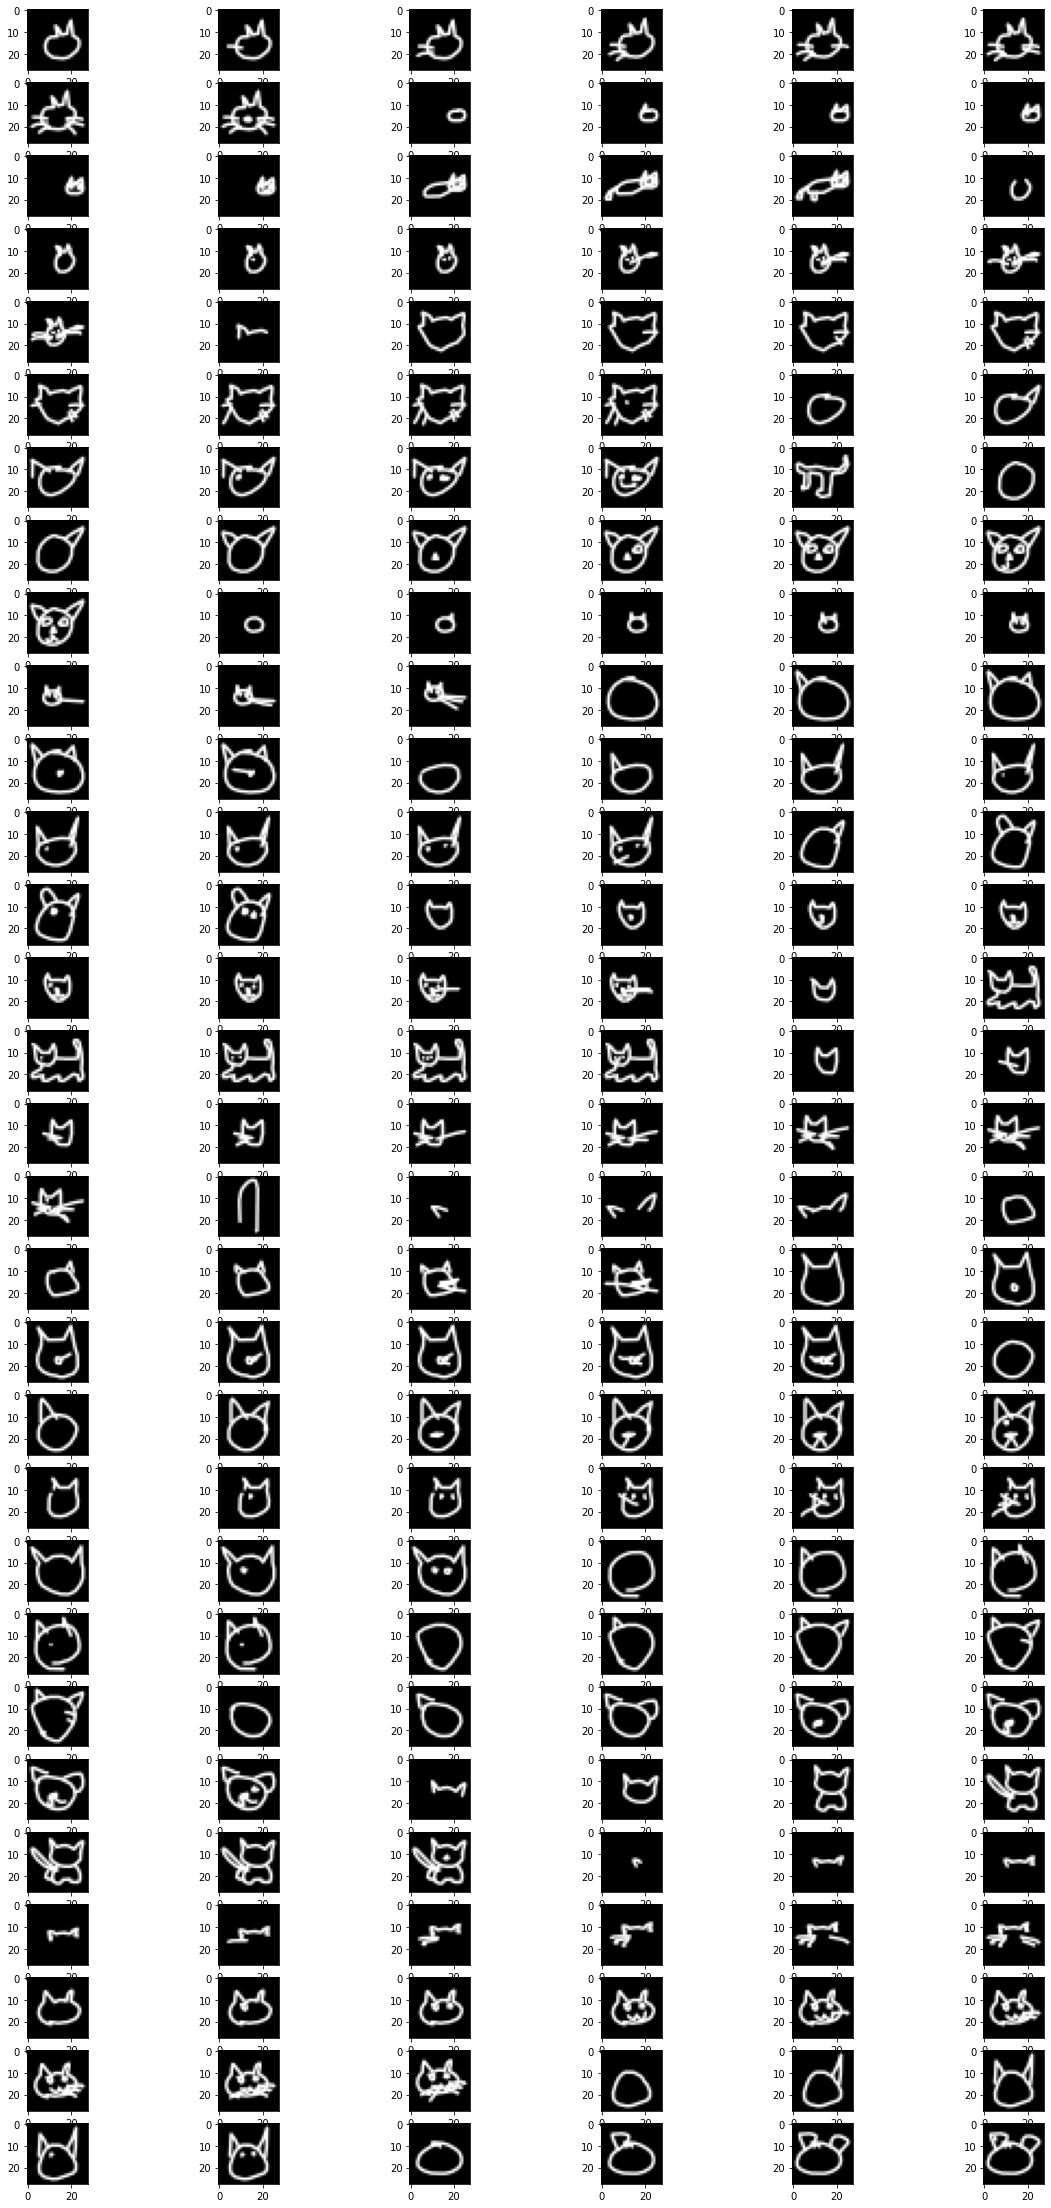

In [48]:
import matplotlib.pyplot as plt

# Create a 4x4 grid of subplots
fig, ax = plt.subplots(30, 6, figsize=(20, 40))

# Loop through the subplots
for i, subplot in enumerate(ax.flat):
    # Add an image to the subplot
    subplot.imshow(vector_to_raster(dataset[i][0])[0].reshape((28, 28)), cmap='gray')

In [22]:
from SketchRNN import Configs

c = Configs(['cat'], 0)

In [23]:
c.load('checkpoints/model-2022-12-05_17:15:48.dict')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.